In [72]:
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cmath

In [148]:
def loadData(fileNameStr):
    df = pd.read_csv(fileNameStr,sep=' ', header=None)
    df.columns = ['cityNumber', 'x', 'y']
    xs = df.y
    ys = df.x
    return xs, ys

In [151]:
#function used to build the distance matrix
def distance(point1, point2):
    return np.sqrt(sum((point1-point2)**2))
def distanceScalar(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def createDistanceMatrix(xs, ys):
    numPoints = len(xs)
    dists = np.ndarray((numPoints,numPoints))
    for i in range(numPoints):
        dists[i,i] = 0
        for j in range(i+1,numPoints):
            dists[i,j] = distanceScalar(xs[i], ys[i], xs[j], ys[j])
            dists[j,i] = dists[i,j]   
    return dists

In [153]:
def routeLength(path, distancesMatrix):
    # index 0 not included in the path as we're assuming 0 is starting point
    curLength = distancesMatrix[0,path[0]]
    for i in range(len(path)-1):
        curLength += distancesMatrix[path[i], path[i+1]]
    curLength += distancesMatrix[path[-1],0]
    return curLength

In [154]:
def visualiseRoute(xs, ys, path, routeLength):
    fig, ax = plt.subplots(1,1)
    dash = [5, 5]
    #ax.scatter([-5,5],[-5,5], visible=False)
    ax.scatter(xs[0],ys[0], color='black')
    ax.scatter(xs[1:], ys[1:], color='blue')
    ax.plot([xs[0],xs[path[0]]],[ys[0],ys[path[0]]], color='red', dashes=dash)
    for i in range(numPoints-2):
        ax.plot([xs[path[i]],xs[path[i+1]]],[ys[path[i]],ys[path[i+1]]], color='red', dashes=dash)
    ax.plot([xs[0],xs[path[-1]]],[ys[0],ys[path[-1]]], color='red', dashes=dash)    
    ax.set_title('Route length: {:.3}'.format(routeLength))

In [193]:
def reformatToZeroStart(fullPath):
    zeroPos = fullPath.index(0)
    res = fullPath[zeroPos+1:] + fullPath[:zeroPos]
                               
    return res

In [194]:
def computeBestPath_sub(initialList, xs, ys):
    # custom algorithm
    # based on creating an initial triangle and adding points with the following rule:
    # add point closest to current center of gravity
    # insert between 2 points so as to minimize current point impact
    # different initialisations of initialList are possible and implemented in the functions:
    # 1 - function computeBestPath_gravity
    # 2 - functioncomputeBestPath_random
    
    path = []     #points used in the path
    path_x = []   #x values of points, used to update g
    path_y = []   #y values of points, used to update
    outstanding = [i for i in range(numPoints)] 
    
    funcDists = createDistanceMatrix(xs, ys)
    
    for el in initialList:
        path.append(el)
        path_x.append(xs[el])
        path_y.append(ys[el])
        outstanding.remove(el)        

    for count in range(0, numPoints-3):
        #calculate center of gravity of current polygon
        g = np.array([np.mean(path_x),np.mean(path_y)])
        
        # Find the point closest to current center of gravity
        sortedOutstanding = sorted(outstanding, key = lambda i: distance(g,np.array([xs[i],ys[i]])))
        pNewName = sortedOutstanding[0]
        pNew = np.array([xs[pNewName],ys[pNewName]])
        
        # Insert the point in the polygon
        # we look for xk in the current polygon such that
        # d(xnew, xk) + d (xnew, xk+1) - d(xk,xk+1) is minimum (add 2 new edges, remove one)

        #initialise
        p = np.array([xs[path[-1]],ys[path[-1]]])
        pNext = np.array([xs[path[0]],ys[path[0]]])        
        pName = path[-1]
        pNextName = path[0]
        minDist = funcDists[pNewName, pName] + funcDists[pNewName, pNextName] - funcDists[pName, pNextName]        
        
        #compare against other possible edges
        minPos = -1
        for i in range(len(path)-1):
            p = np.array([xs[path[i]],ys[path[i]]])
            pNext = np.array([xs[path[i+1]],ys[path[i+1]]])
            pName = path[i]
            pNextName = path[i+1]
            compDist = funcDists[pNewName, pName] + funcDists[pNewName, pNextName] - funcDists[pName, pNextName]
            if compDist < minDist:
                minDist = compDist
                minPos = i

        path.insert(minPos+1, pNewName)
        path_x.append(xs[pNewName])
        path_y.append(ys[pNewName])
        outstanding.remove(pNewName)

    res = reformatToZeroStart(path)

    return res

In [195]:
def computeBestPath_gravity(xs, ys):
    # pick the first 3 points that are closest to the overall center of gravity
    
    g = np.array([np.mean(xs),np.mean(ys)])  # center of gravity
    sortedOutstanding = sorted([i for i in range(numPoints)], key = lambda i: distance(g,np.array([xs[i],ys[i]])))
    initialList = [sortedOutstanding[i] for i in range(3)]
    
    return computeBestPath_sub(initialList, xs, ys)

In [196]:
def computeBestPath_random(xs, ys):
    # compute first 3 points at random
    initialList = random.sample(range(numPoints),3)
    
    return computeBestPath_sub(initialList, xs, ys)

In [200]:
def computeRadarPath(xs, ys):
    # custom algorithm
    # Idea: computer center of gravity
    # consider this as the center of a circle
    # sort points based on their angle in polar coordinates 
    gx = np.mean(xs)
    gy = np.mean(ys)
    
    allVals = [i for i in range(numPoints)]
    sortedVals = sorted(allVals, key = lambda i: np.angle(complex(xs[i]-gx, ys[i]-gy)))
    
    res = reformatToZeroStart(sortedVals)
        
    return res

In [201]:
def computeNearestNeighbour(xs, ys):

    g = np.array([np.mean(xs),np.mean(ys)])  # center of gravity
    path = []     #points used in the path
    path_x = []   #x values of points, used to update g
    path_y = []   #y values of points, used to update
    outstanding = [i for i in range(numPoints)] 

    # initialise path with point closest to global center of gravity
    sortedOutstanding = sorted(outstanding, key = lambda i: distance(g,np.array([xs[i],ys[i]])))
    
    first = sortedOutstanding[0]
    path.append(first)
    outstanding.remove(first)
    
    curPoint = np.array([xs[first],ys[first]])
    
    for count in range(0, numPoints-1):
        sortedOutstanding = sorted(outstanding, key = lambda i: distance(curPoint,np.array([xs[i],ys[i]])))
        pNewName = sortedOutstanding[0]
        path.append(pNewName)
        outstanding.remove(sortedOutstanding[0])
        curPoint = np.array([xs[pNewName],ys[pNewName]])

    res = reformatToZeroStart(path)
        
    return res

In [160]:
from jmetal.problem.singleobjective.tsp import TSP

from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.config import store
from jmetal.core.problem import Problem
from jmetal.core.operator import Mutation, Crossover, Selection
from jmetal.util.termination_criterion import TerminationCriterion
from jmetal.util.generator import Generator
from jmetal.util.evaluator import Evaluator
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.operator.crossover import PMXCrossover
from typing import TypeVar, List
from jmetal.util.termination_criterion import StoppingByEvaluations

In [161]:
class myTSP(TSP):
    def __init__(self, distMatrix, numPoints ):
        super(TSP, self).__init__()

        self.distance_matrix = distMatrix
        self.obj_directions = [self.MINIMIZE]
        self.number_of_variables = numPoints
        self.number_of_objectives = 1
        self.number_of_constraints = 0

In [162]:
class GeneticAlgorithmExt(GeneticAlgorithm):
    def __init__(self,
                 problem: Problem,
                 population_size: int,
                 offspring_population_size: int,
                 mutation: Mutation,
                 crossover: Crossover,
                 selection: Selection,
                 termination_criterion: TerminationCriterion = store.default_termination_criteria,
                 population_generator: Generator = store.default_generator,
                 population_evaluator: Evaluator = store.default_evaluator):
        super(GeneticAlgorithmExt, self).__init__(problem, population_size, offspring_population_size, mutation, crossover, selection, termination_criterion, population_generator, population_evaluator)
        self.averageFitHisto = []
        self.bestFitHisto = []
        self.intCount = 0
    def update_progress(self):
        self.evaluations += self.offspring_population_size

        observable_data = self.get_observable_data()
        self.observable.notify_all(**observable_data)
        
        self.intCount+=1
        fits  = np.array([sol.objectives[0] for sol in self.solutions])
        self.averageFitHisto.append(np.mean(fits))
        self.bestFitHisto.append(np.min(fits))

In [163]:
S = TypeVar('S')

class RouletteWheelSelection2(Selection[List[S], S]):
    """Performs roulette wheel selection.
    """

    def __init__(self):
        super(RouletteWheelSelection2).__init__()

    def execute(self, front: List[S]) -> S:
        if front is None:
            raise Exception('The front is null')
        elif len(front) == 0:
            raise Exception('The front is empty')

        maximum = sum([solution.objectives[0] for solution in front])
        rand = random.uniform(0.0, maximum)
        value = 0.0

        for solution in front:
            value += solution.objectives[0]

            if value > rand:
                return solution

        return None

    def get_name(self) -> str:
        return 'Roulette wheel selection'


In [700]:
class TSP_evaluator:
    def __init__(self, distMatrix, propChange):
        self.mDists = distMatrix
        self.dim = distMatrix.shape[0]
        self.pool = [i for i in range(self.dim-1)]
        self.propChange = propChange
        
    def evaluate(self, path):
        return routeLength(path, self.mDists)
    
    def randomSolution(self, initSolution, searchRadius):
        return self.rebranching(initSolution, searchRadius)
    
    def permutation(self, initSolution, searchRadius):
        n = len(initSolution)
        k1 = random.randint(0, n-1)
        intRadius = int((n - 1) * searchRadius + 1)
        r = random.randint(1, intRadius)
        k2 = (k1+r) % n
        newSolution = list(initSolution)
        newSolution[k1], newSolution[k2] = newSolution[k2], newSolution[k1]
        return newSolution
    
    def multipermutation(self, initSolution, searchRadius):
        n = len(initSolution)
        numChange = int(n*self.propChange)
        intRadius = int((n - 1) * searchRadius + 1)
        newSolution = list(initSolution)
        listChange = random.sample(self.pool, numChange)
        for el in listChange:
            r = random.randint(1, intRadius)
            k2 = (el+r) % n    
            newSolution[el], newSolution[k2] = newSolution[k2], newSolution[el]
        return newSolution
    
    def rebranching(self, initSolution, searchRadius):
        k1, k2 = random.sample(self.pool, 2)
        k1, k2 = min(k1,k2), max(k1, k2)
        newSolution = list(initSolution)
        for l in range(1+int(0.5*(k2-k1-1))):
            newSolution[k1+l], newSolution[k2-l] = newSolution[k2-l], newSolution[k1+l]
        return newSolution
    
    def rebranching2(self, initSolution, searchRadius):
        n = len(initSolution)
        intRadius = int((n - 1) * searchRadius + 1)
        k1 = random.randint(0,n-1)
        r = random.randint(1, intRadius)
        k2 = (el+r) % n
        
        k1, k2 = min(k1,k2), max(k1, k2)
        newSolution = list(initSolution)
        for l in range(1+int(0.5*(k2-k1-1))):
            newSolution[k1+l], newSolution[k2-l] = newSolution[k2-l], newSolution[k1+l]
        return newSolution
    
    def solutionTest(self, initSolution, searchRadius, numChanges):
        newSolution = list(initSolution)
        changeList = random.sample(self.pool, int(numChanges*self.propChange))
        for k in changeList:
            newSolution[k], newSolution[k-1] = newSolution[k-1], newSolution[k]
        return newSolution

In [701]:
def simulatedAnnealing(objFun, minMax, xStart, initTemp, finalTemp, coolFactor, searchRadius, maxIterPerTemp):
    # objFun : the function to optimize
    # minMax : 1 to minimize, -1 to maximize
    # xStart: starting point of the search
    # initTemp: initial Temperature
    # finalTemp: finalTemperature
    # coolFactor: parameters <1
    #             At each step temperature change, new temp = current temp * coolFactor
    # searchRadius: the radius of the ball inside which we look for a solution. 
    #               When current temperature < 1, the new search radius = current search radius * coolFactor
    # maxIterTemp: the maximum number of iterations we perform once we found a new optimum at a given temperature
    #              This defines the equilibrium condition at a given temperature, ie we've iterated maxIterPerTemp 
    #              without finding a better solution
    
    # Note on implementation:
    # When the current temperature falls below 1, the search radius gets multiplied by the coolFactor
    # This allows for intensification when we're near the end of the algorithm
    
    # Please note this is a custom implementation of simulated annealing. It was implemented so as to 
    # allow better identification of which parameter to change when convergence isn't obtained.
    # To achieve this, the algorithm "normalizes" delta (the change in energy) using the average delta 
    # at the equilibrium position for a given temperature. This avoids having to adjust for initial temperatures
    # and final temperatures so that the order of magnitude depends on the energy delta. We get a better control
    # of the barrier level for diversification.
    
    curTemp = initTemp
    xBest = np.copy(xStart)
    fxBest = objFun.evaluate(xBest) * minMax
    
    # to store all evaluated points and associated function values
    xIter = []
    fxIter = []
    
    # to store best x and f(xBest) for a given temperature
    bestxTemp = []
    bestfxTemp = []
    probs = []
    a=(len(xStart)-1)/(finalTemp-initTemp)
    b=1-a*curTemp
        
    iterCount = 0
    while curTemp > finalTemp:
        #restarting from our equilibrium point (ie best value so far)
        x = np.copy(xBest)
        fx = fxBest
        iterCount = 0
        deltaAvg = 0
        probVec = []
        
        #we reach equilibrium at this temperature if we iterated maxIterPerTemp times without improving the best solution
        while iterCount < maxIterPerTemp:
            numchanges = int(a*curTemp+b)
            
            xTest = objFun.randomSolution(x, searchRadius)
            fxTest = objFun.evaluate(xTest) * minMax
            delta = fxTest - fx
            deltaAvg = (iterCount*deltaAvg+abs(delta))/(iterCount+1)
            
            if delta >0:
                lim_prob = np.exp(-(delta/deltaAvg)/curTemp)
                probVec.append(lim_prob)

            if delta <= 0 or np.random.random() < np.exp(-(delta/deltaAvg)/curTemp):
                x = np.copy(xTest)
                fx = fxTest
            iterCount+=1
            if fxTest < fxBest:
                #we improved the best solution, reset iterCount to 0 and store new best solution 
                iterCount = 0
                deltaAvg = 0
                xBest = np.copy(xTest)
                fxBest = fxTest

            xIter.append(x)
            fxIter.append(objFun.evaluate(x))
        bestxTemp.append(xBest)
        bestfxTemp.append(objFun.evaluate(xBest))
        probs.append(np.mean(probVec))
        if curTemp <1:
            # below 1 degree, decrease the search radius to increase intensification
            searchRadius *= coolFactor
        curTemp *= coolFactor

    return bestxTemp, bestfxTemp, xIter, fxIter, probs

In [702]:
# Djibouti_38_coordinates
# Qatar_194_coordinates
# Oman_1979_coordinates

optimums = {}
optimums['Djibouti_38_coordinates.tsp'] = 6656
optimums['Qatar_194_coordinates.tsp'] = 9352
optimums['Oman_1979_coordinates.tsp'] = 86891

fileName = 'Djibouti_38_coordinates.tsp'
knownOptimum = optimums[fileName]

xs, ys = loadData(fileName)
numPoints = len(xs)

dists = createDistanceMatrix(xs, ys)

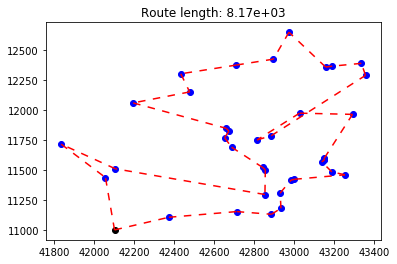

In [689]:
startTime = time.time()
pathA = computeBestPath_gravity(xs, ys)
pathALength = routeLength(pathA, dists)
visualiseRoute(xs, ys, pathA, pathALength)
runTimeA = time.time() - startTime

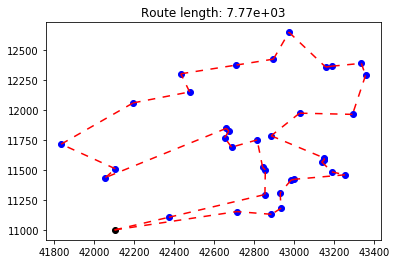

In [690]:
startTime = time.time()
pathB = computeBestPath_random(xs, ys)
pathBLength = routeLength(pathB, dists)
visualiseRoute(xs, ys, pathB, pathBLength)
runTimeB = time.time() - startTime

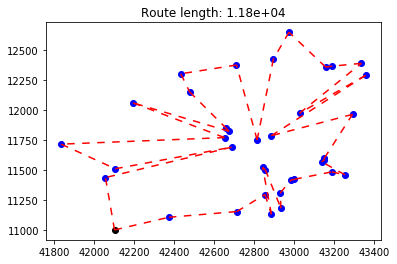

In [691]:
startTime = time.time()
pathC = computeRadarPath(xs, ys)
pathCLength = routeLength(pathC, dists)
visualiseRoute(xs, ys, pathC, pathCLength)
runTimeC = time.time() - startTime

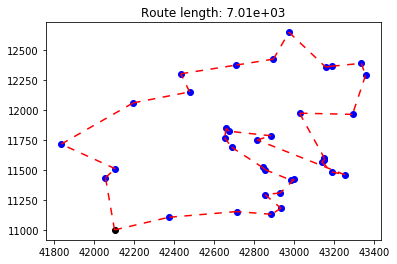

In [692]:
startTime = time.time()
pathD = computeNearestNeighbour(xs, ys)
pathDLength = routeLength(pathD, dists)
visualiseRoute(xs, ys, pathD, pathDLength)
runTimeD = time.time() - startTime

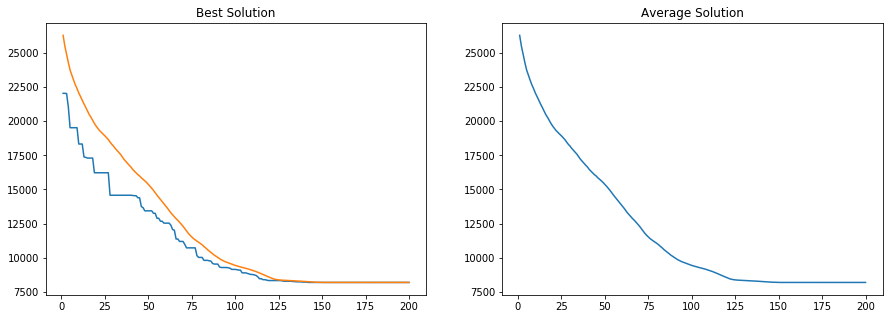

In [655]:
problem = myTSP(dists, numPoints)

maxGen = 200
popSize = 500
offSpringSize = 500

algorithm = GeneticAlgorithmExt(
    problem=problem,
    population_size=popSize,
    offspring_population_size=offSpringSize,
    mutation=PermutationSwapMutation(0.4),
    crossover=PMXCrossover(1.0),
    #selection=BinaryTournamentSelection(MultiComparator([FastNonDominatedRanking.get_comparator(), CrowdingDistance.get_comparator()])),
    #selection=BinaryTournamentSelection(),
    selection=RouletteWheelSelection2(),
    #selection=RankingAndFitnessSelection2(),
    termination_criterion=StoppingByEvaluations(max_evaluations=popSize + maxGen*offSpringSize)
    )

algorithm.run()
result = algorithm.get_result()
pathE = reformatToZeroStart(result.variables)
pathELength = result.objectives[0]
runTimeE = algorithm.total_computing_time

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot([i for i in range(1, maxGen+1)], algorithm.bestFitHisto)
ax[0].plot([i for i in range(1, maxGen+1)], algorithm.averageFitHisto)
ax[0].title.set_text('Best Solution')
ax[1].plot([i for i in range(1, maxGen+1)], algorithm.averageFitHisto)
ax[1].title.set_text('Average Solution')

6659.431532931465


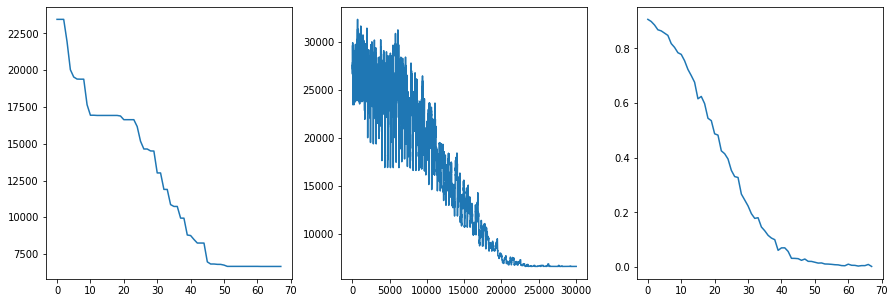

In [703]:
probChange = 0.15

tspEval = TSP_evaluator(dists, probChange)

initTemp = 10  #2
finalTemp = 0.008   #0.01
coolFactor = 0.9
searchRadius = 0.95
maxIterTemp = 10*numPoints

minMax = 1  #minimize = 1, maximize = -1
x = [i for i in range(1, numPoints)]
random.shuffle(x)

startTime = time.time()
pathFs, pathFLengths, xEvals, fxEvals,probs = simulatedAnnealing(tspEval, minMax, x, initTemp, finalTemp, coolFactor, searchRadius, maxIterTemp)
runTimeF = time.time() - startTime

pathF = pathFs[-1]
pathFLength = pathFLengths[-1]

print(pathFLength)

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot([i for i in range(tempZoom, len(pathFLengths))], np.array(pathFLengths[tempZoom:]))
ax[1].plot([i for i in range(len(xEvals))], np.array(fxEvals))
ax[2].plot([i for i in range(len(probs))], np.array(probs))

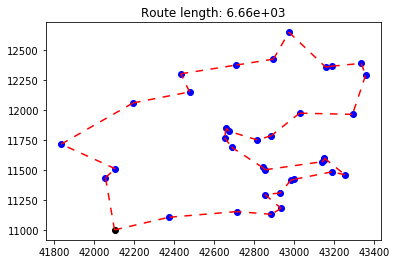

In [704]:
visualiseRoute(xs, ys, pathF, pathFLength)

In [705]:
print('optimal solution: {:,.0f}\n'.format(knownOptimum))

print('custom_gravity: {:,.0f}; run time: {:.1f}'.format(pathALength, runTimeA))
print('custom_random: {:,.0f}; run time: {:.1f}'.format(pathBLength, runTimeB))
print('custom_radar: {:,.0f}; run time: {:.1f}'.format(pathCLength, runTimeC))
print('nearest_neighbour: {:,.0f}; run time: {:.1f}'.format(pathDLength, runTimeD))
print('GA: {:,.0f}; run time: {:.1f}'.format(pathELength, runTimeE))
print('SA: {:,.0f}; run time: {:.1f}'.format(pathFLength, runTimeF))

optimal solution: 6,656

custom_gravity: 8,168; run time: 0.2
custom_random: 7,774; run time: 0.2
custom_radar: 11,805; run time: 0.1
nearest_neighbour: 7,007; run time: 0.1
GA: 8,178; run time: 60.4
SA: 6,659; run time: 3.1
